<a href="https://colab.research.google.com/github/dmesonero/Nerf/blob/main/tiny_nerf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Verifica si el código está siendo ejecutado en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Importa bibliotecas necesarias
import os, sys

# Habilita la ejecución ansiosa (eager execution) en TensorFlow 1 (compatibilidad)
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

# Importa la barra de progreso (tqdm) para cuadernos de Jupyter en Colab
from tqdm import tqdm_notebook as tqdm

# Importa bibliotecas numéricas y de visualización
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Verifica si el archivo 'tiny_nerf_data.npz' no existe en el sistema de archivos local
if not os.path.exists('tiny_nerf_data.npz'):
    # Si el archivo no existe, descarga el archivo desde la siguiente URL utilizando wget
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-12-12 08:31:01--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-12-12 08:31:01--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  20.9MB/s    in 0.6s    

2023-12-12 08:31:02 (20.9 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



# Load Input Images and Poses

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


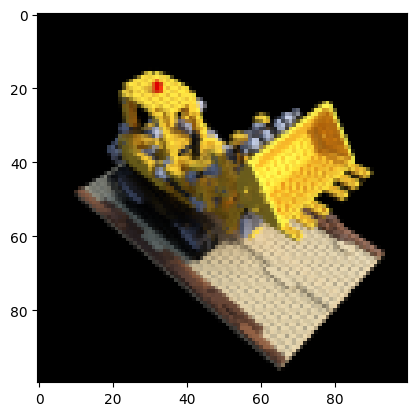

In [3]:
# Cargar datos desde el archivo 'tiny_nerf_data.npz' utilizando NumPy
data = np.load('tiny_nerf_data.npz')

# Extraer arrays específicos del archivo
images = data['images']  # Imágenes capturadas desde diferentes puntos de vista
poses = data['poses']    # Posiciones y orientaciones de la cámara correspondientes a las imágenes
focal = data['focal']    # Longitud focal de la cámara
H, W = images.shape[1:3]  # Obtener dimensiones de las imágenes (altura y ancho)
print(images.shape, poses.shape, focal)

# Seleccionar una imagen y su correspondiente posición y orientación para prueba
testimg, testpose = images[101], poses[101]

# Reducir el conjunto de datos a las primeras 100 imágenes
images = images[:100, ..., :3]  # Seleccionar las primeras 100 imágenes y conservar solo los canales RGB
poses = poses[:100]             # Seleccionar las primeras 100 posiciones y orientaciones de la cámara

# Visualizar la imagen de prueba
plt.imshow(testimg)
plt.show()

# Optimize NeRF

In [10]:
# Función para agregar posiciones codificadas a un tensor x
def posenc(x):
    rets = [x]
    for i in range(L_embed):
        for fn in [tf.sin, tf.cos]:
            rets.append(fn(2.**i * x))
    return tf.concat(rets, -1)

# Número de capas de codificación de posición
L_embed = 6
# Función de codificación de posición
embed_fn = posenc
# Puedes comentar o descomentar las siguientes líneas para cambiar el comportamiento
# L_embed = 0
# embed_fn = tf.identity

# Función para inicializar el modelo
def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu: tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3 * 2 * L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i % 4 == 0 and i > 0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Función para obtener los rayos de la cámara
def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i - W * 0.5) / focal, -(j - H * 0.5) / focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

# Función para renderizar rayos
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    # Función auxiliar para procesar lotes de datos
    def batchify(fn, chunk=1024*32):
        return lambda inputs: tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Calcular puntos de consulta en 3D
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Ejecutar la red neuronal
    pts_flat = tf.reshape(pts, [-1, 3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Calcular opacidades y colores
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Renderizar volumen
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1. - tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1. - alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

0 0.0350937032699585 secs per iter


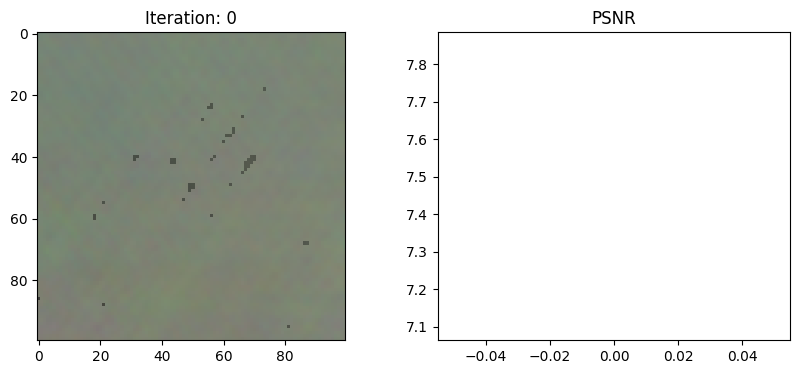

50 0.31582112312316896 secs per iter


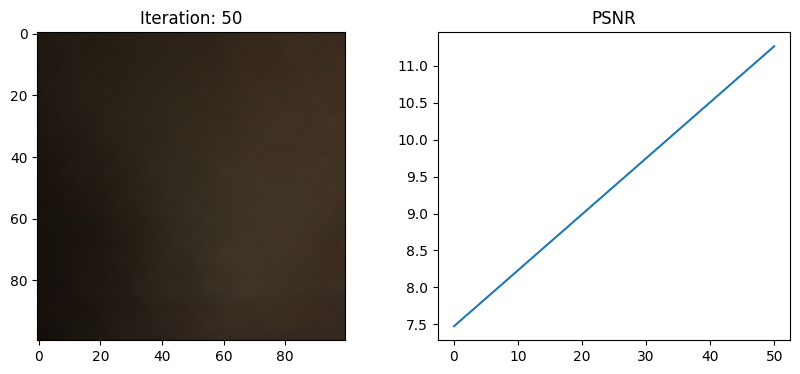

100 0.25519330978393556 secs per iter


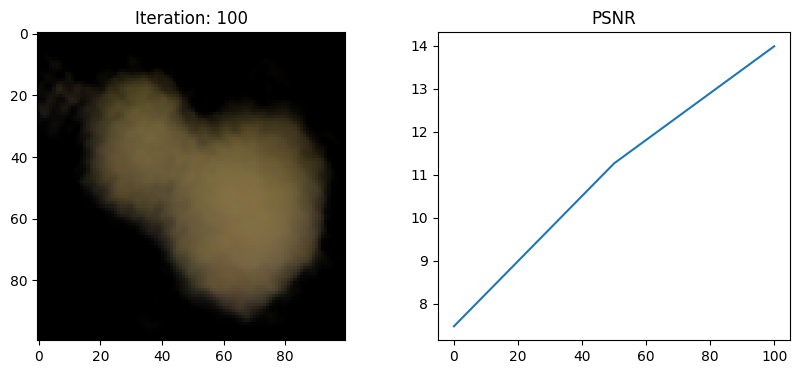

150 0.25226757526397703 secs per iter


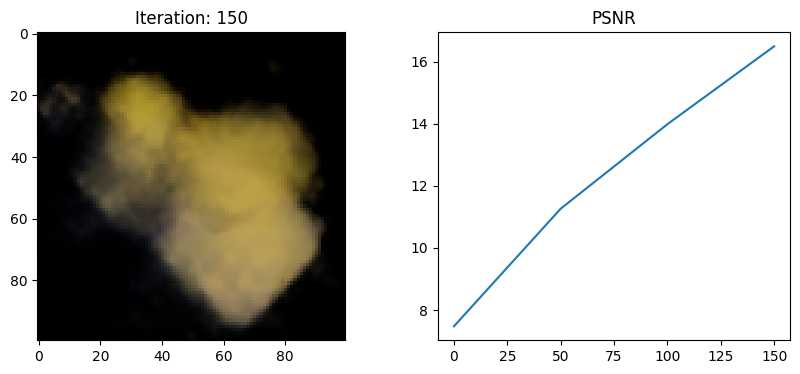

200 0.24616666793823241 secs per iter


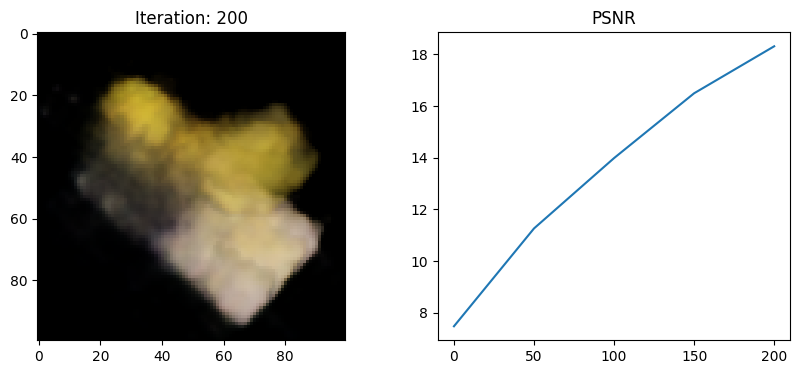

250 0.2403700828552246 secs per iter


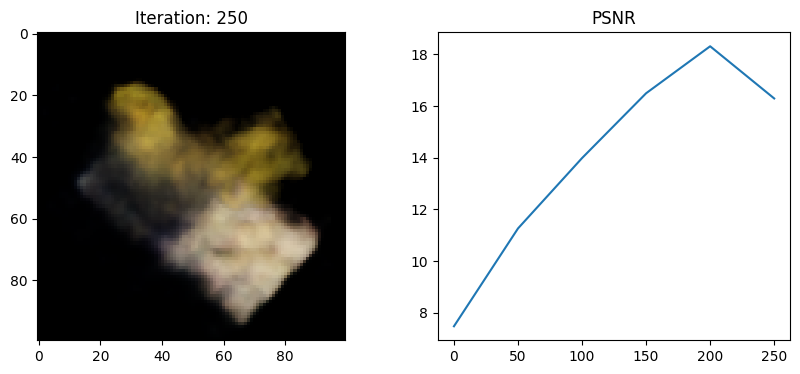

300 0.24019164085388184 secs per iter


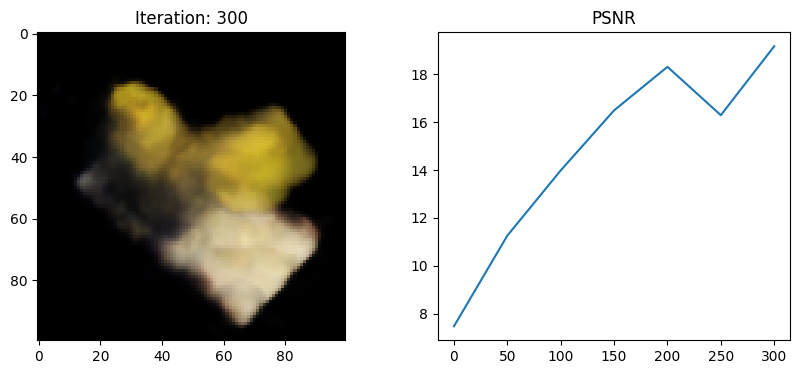

350 0.2450493049621582 secs per iter


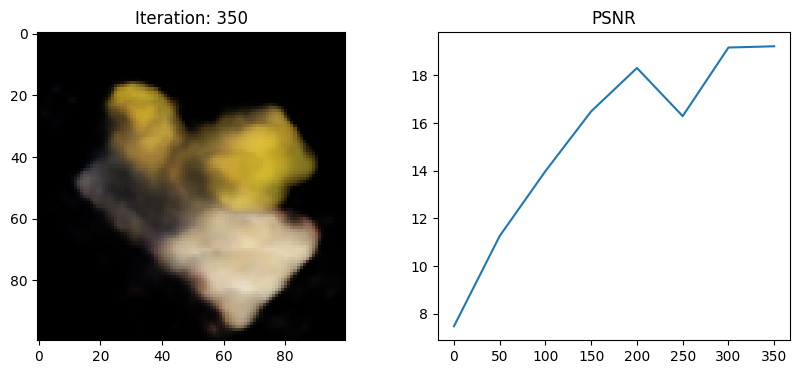

400 0.2476271629333496 secs per iter


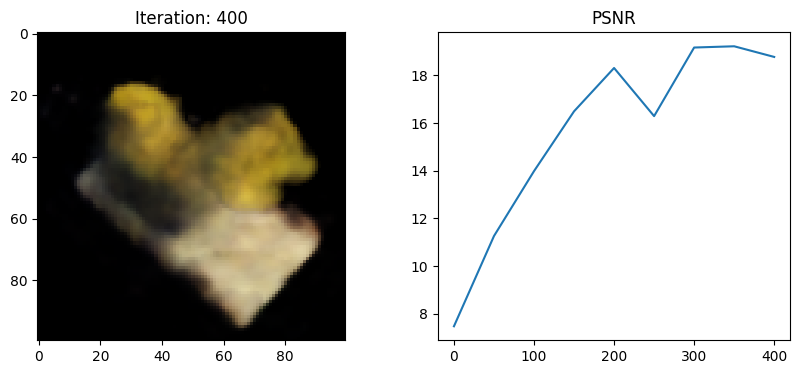

450 0.2653874444961548 secs per iter


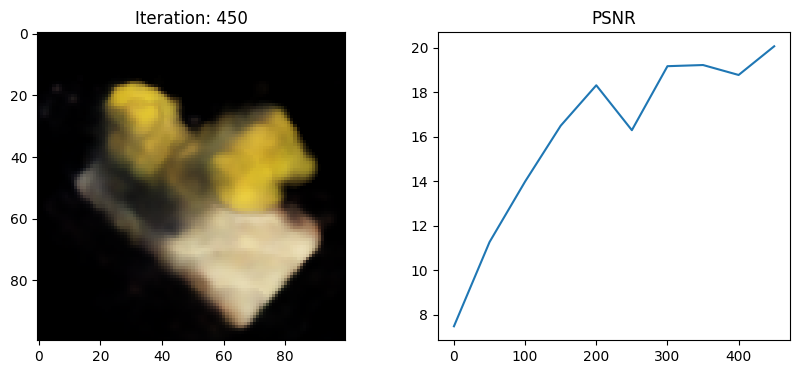

500 0.24874650001525878 secs per iter


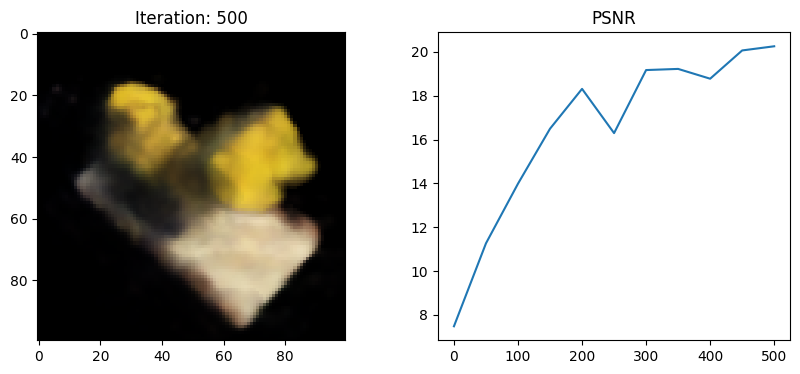

Done


In [13]:
# Inicializar el modelo y el optimizador
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

# Número de muestras para renderización
N_samples = 20
# Número de iteraciones de entrenamiento
N_iters = 500
# Listas para almacenar resultados
psnrs = []
iternums = []
# Frecuencia de impresión durante el entrenamiento
i_plot = 50

# Tiempo de inicio del entrenamiento
import time
t = time.time()

# Bucle de entrenamiento
for i in range(N_iters+1):

    # Seleccionar una imagen aleatoria del conjunto de datos
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]

    # Calcular rayos para la imagen seleccionada
    rays_o, rays_d = get_rays(H, W, focal, pose)

    # Calcular la renderización y la pérdida
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))

    # Calcular gradientes y aplicar la optimización
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Imprimir resultados periódicamente
    if i % i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Renderizar la vista de prueba para el registro
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        # Registrar métricas y visualizar resultados
        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

# Mensaje de finalización del entrenamiento
print('Done')

# Interactive Visualization

In [14]:
# Configuración para visualización en el cuaderno Jupyter
%matplotlib inline
from ipywidgets import interactive, widgets

# Funciones de transformación para la matriz de vista
trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)

# Función para generar una pose esférica
def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

# Función de renderizado y visualización interactiva
def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb, 0, 1)

    # Visualización de la imagen renderizada
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

# Función para crear un slider interactivo
sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

# Definición de parámetros y sus rangos para la interfaz interactiva
names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

# Crear la interfaz interactiva con sliders para cada parámetro
interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [15]:
# Lista para almacenar los frames del video
frames = []

# Bucle para generar frames de un giro esférico
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    # Crear una pose esférica con parámetros específicos
    c2w = pose_spherical(th, -30., 4.)

    # Calcular rayos para la vista actual
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])

    # Renderizar la escena y guardar el frame
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255 * np.clip(rgb, 0, 1)).astype(np.uint8))

# Crear un archivo de video a partir de los frames
import imageio
video_filename = 'video.mp4'
imageio.mimwrite(video_filename, frames, fps=30, quality=7)

<ipython-input-15-b2fbdb1436d9>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

In [16]:
# Importar clases y funciones necesarias
from IPython.display import HTML
from base64 import b64encode

# Leer el archivo de video 'video.mp4' en formato binario
mp4 = open('video.mp4', 'rb').read()

# Codificar el contenido del archivo de video en base64
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Crear un elemento de video HTML para mostrar el video en el cuaderno
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)